# Building a Case for Building Intelligence
#### a.k.a. My bid for an OpenAI fellowship

The visualizations and analyses in this notebook are based on how OpenAI and their employess describe themselves and the problems they find important. Like any cultural or technical niche, AI and machine learning research

## Part 1: t-SNE of Short Bios

1. Decompose openAI short bios to bag of words vectors
2. Use t-SNE to map the BOW decompositions to low dimensional subspace 
3. Visualize and calculate l2 distance between openAI bios and candidate bios for fellowship application

## Part 2: Semantic Hashing of Job Descriptions

This technique is based on a paper from Ruslan Salakhutdinov and Geoffrey Hinton, which I first learned about when taking [Hinton's Coursera](https://www.coursera.org/learn/neural-networks/) course on neural networks


Geoffrey Hinton. [Semantic Hashing](http://www.cs.toronto.edu/~rsalakhu/papers/sdarticle.pdf). Journal of Approximate Reasoning. 2009. [Conference version: Semantic Hashing](http://www.cs.utoronto.ca/~rsalakhu/papers/semantic_final.pdf). 

I built some tools for this in a [Github repository](https://github.com/theScinder/semantHashJobDescriptions)

## Part 3: Using an LSTM to Write my Cover Letter





In [264]:
import numpy as np
import matplotlib.pyplot as plt

# Sci-kit learn used for tsne
import sklearn
from sklearn.manifold import TSNE

# imports for scraping websites for job description 
import urllib.request
import urllib
from urllib.error import HTTPError
from bs4 import BeautifulSoup as bs

import time

In [302]:
# Import functions for training neural nets and RBMS
# https://github.com/theScinder/neuroFun/blob/master/neuroFun.py

#from neuroFun import *

def sigmoid(z):
    #Returns the logistic of the value z
    mySig = 1 / (1+np.exp(-z))
    return mySig

def sigmoidGradient(z):
    #return the gradient of a sigmoid function at value z
    mySigGrad = sigmoid(z)*(1-sigmoid(z))
    return mySigGrad

    

def hidToVis(rbmW,hidStates):
    visProb = np.dot(rbmW.T,hidStates)
    visProb = sigmoid(visProb)
    return visProb

def visToHid(rbmW,visStates):
    hidProb = np.dot(rbmW,visStates)
    hidProb = sigmoid(hidProb)
    return hidProb

def initRBMW(hLayer,vLayer,mySeed=1.0):
    np.random.seed(mySeed)
    rbmW = np.random.random((hLayer,vLayer))
    return rbmW

def sampPRand(myInput,seed=1):
    #Compare input to pseudo-random variables
    myTest = myInput > np.random.random(np.shape(myInput))
    return myTest * 1

def myGoodness(rbmW,hidStates,visStates):
    #m = np.shape(visStates)[1]
    E = - np.mean(np.dot(np.dot(rbmW, visStates).T, hidStates));
    G = -(E); 
    return G
    
def myGoodnessGrad(hidStates,visStates):
    m = np.shape(visStates)[1];
    myGG = np.dot(visStates,hidStates.T)
    myGG = myGG.T/ m;
    return myGG

def trainRBMLayers(a0,hiddenLayers,lR,myIter):
    #Train an RBM layer based on visible input layer a0
    #a0 - visible units
    #hiddenLayers - number of hidden layers
    #lR - learning rate
    #myIter - number of iterations to train
    myTest = a0
    J = []
    rbmW = initRBMW(hiddenLayers,np.shape(myTest)[0],1)
    for j in range(myIter):
        myTest = sampPRand(a0)
        myHid = visToHid(rbmW,myTest)
        myHid0 = myHid
        #print(myHid)
        myHid = sampPRand(myHid)
        #print(myHid[:,10])
        myDream = hidToVis(rbmW,myHid)
        E = (a0-myDream)
        J.append(np.mean(np.abs(E)))
        myDream = sampPRand(myDream)
        myReconProb = visToHid(rbmW,myDream)
        myRecon = sampPRand(myReconProb)
        myPos = myGoodnessGrad(myHid,myTest)

        myNeg = myGoodnessGrad(myRecon,myDream)
        rbmW = rbmW + lR* (myPos-myNeg)
        if ( j % (myIter/10) == 0):
            G = myGoodness(rbmW,myHid,myTest)
            print("Iteration " + str(j)+" Error = " + str(np.mean(np.abs(E))))
            print("Goodness = " + str(G))
            
    plt.plot(J)
    plt.show()
    print("Finished with RBM training of size " + str(np.shape(rbmW.T)))
    return rbmW.T

#forward propagation 
def forProp(myInputs,myWeights):
    #print(np.shape(myInputs))
    #print(np.shape(myWeights[0]))
    zn = [] #np.dot(myInputs,myWeights[0])
    an = [] #sigmoid(zn)
    if(0):
        for n in range(len(myWeights)):
            zn.append(np.zeros((np.shape(myWeights[n][1])[0],np.shape(a0)[0])))
            an.append(np.zeros((np.shape(myWeights[n][1])[0],np.shape(a0)[0])))
        
    
    #zn[0,:] = np.array([np.dot(myInputs,myWeights[0])])
    #an[0,:] = sigmoid(zn[0,:])
    if(0):
        zn[0] = np.dot(myInputs.T,myWeights[0])
        an[0] = sigmoid(zn[0])
    zn.append(np.squeeze(np.dot(myWeights[0].T,myInputs)))
    #print(np.shape(zn))
    an.append(sigmoid(zn[0]))
    
    for n in range(1,len(myWeights)):
        #print(np.shape(an))
        #print(np.shape(myWeights[n]))
        if(0):
            print(n)
            zn[n] = np.dot(myWeights[n].T,an[n-1])
            an[n] = sigmoid(zn[n])
        if(n < len(myWeights)):
            zn.append(np.dot(myWeights[n].T,an[n-1]))
            an.append(sigmoid(zn[n]))
        else: 
            #last layer is linear
            zn.append(np.dot(myWeights[n].T,an[n-1]))
            an.append((zn[n]))
        #print("shape of layer n = %i "%n,np.shape(an[n]))
        #print(np.shape(an))
    #print(np.shape(an[0]))
    #print(np.shape(np.squeeze(an)))
    return an,zn



#back propagation function

def backProp(myInputs,myTarget,myWeights,myIter=10,lR=1e-5,myLambda=0,myMom=1e-5,dropout=False):
    #init momentum
    momSpeed = []
    #init weight penalties
    wPen = []
    #init gradients
    dGrad = []
    Delta = []
    for n in range(len(myWeights)): #-1,-1,-1):
        wPen.append(0*myWeights[n])
        dGrad.append(0*myWeights[n])
        momSpeed.append(0*myWeights[n])
        Delta.append(0*myWeights[n])
        #print(np.shape(wPen[n]))
        #print(np.shape(dGrad[n]))
        #print(np.shape(momSpeed[n]))
    m = m = np.shape(myInputs)[1]
   
    myFreq = int(myIter/10)
  
    print("Begin Training . . . ")
    for i in range(myIter):
        #Run forward propagation.
        myOutput, myZ = forProp(myInputs,myWeights)
        
        #print(np.shape(myZ[0]))
        #use squared error as objective function
        # print("target and output shape", myTarget.shape,myOutput[len(myOutput)-1].shape)
        loss = np.mean(((myTarget-myOutput[len(myOutput)-1])**2),axis=1)
        d = []
        #print("loss shape ",loss.shape)
        #gradient at the output
        dy = ((myTarget-myOutput[len(myOutput)-1]))#,axis=1)
        
        #print("dy and last layer shape ",dy.shape,myOutput[len(myOutput)-2].shape)
        #gradient for hidden to output
        d.append(dy) #(np.dot(dy,myOutput[len(myOutput)-2].T).T))
        #print("last layer error shape ", np.shape(d[0]))
        

        if(i%myFreq == 0):
            print("Iteration " + str(i) + " Mean square error = "+str(np.mean(np.abs(loss))))

    
        for n in range(len(myWeights)-1,-1,-1):
            #
            #print(np.dot(myWeights[n],d[len(d)-1]).shape, sigmoidGradient(myZ[n-1]).shape)
            d.append(np.dot(myWeights[n],d[len(d)-1]) * sigmoidGradient(myZ[n-1]))
            

        for n in (range(len(myWeights)-1,-1,-1)):
           
            #print((np.array(myOutput[n-1]).T).shape
            #           ,(np.array(d[len(d)-(n+2)]).shape))

            Delta[n] = np.array(np.dot(np.array(d[len(d)-(n+2)]),\
                              np.array(myOutput[n-1]).T))
            Delta[n]= Delta[n].T / m
              
        
        for n in (range(len(myWeights)-1,-1,-1)):
            # regularization
            wPen[n] = myLambda * myWeights[n]
            #print("wpen shape",wPen[n].shape)
            
        for n in (range(len(myWeights)-1,-1,-1)):
            dGrad[n] = Delta[n] +wPen[n]
            momSpeed[n] = myMom*momSpeed[n] + dGrad[n]
            
            myWeights[n] = myWeights[n] + momSpeed[n] * lR
            #print(np.mean(Theta3))
        #print("Training Finished, avg error = "+str(np.mean(np.abs(E))))
        #print(E)
    return myWeights

In [277]:
print(np.mean(X0))

-3.080239209017341e-18


In [267]:
# job descriptions from openAI
myAddys = ['https://jobs.lever.co/openai/f5c8d70e-c8a2-4696-82e1-635d106e649c']
myAddys.append('https://jobs.lever.co/openai/ccb797f6-242d-4d83-9ed3-093db9dff172')
myAddys.append('https://jobs.lever.co/openai/588c1d80-4632-4d5c-a535-9f2c8c80c501')
myAddys.append('https://jobs.lever.co/openai/a0d3b158-14a0-48db-b38c-1c94bb18f69b')

# job descriptions from AI^2
myAddys.append('https://allenai.org/jobs/job/young-investigators-program-209503.html')
myAddys.append('https://allenai.org/jobs/job/research-scientist-aristo-897549.html')
myAddys.append('https://allenai.org/jobs/job/research-scientist-209509.html')
myAddys.append('https://allenai.org/jobs/job/research-internships-209513.html')

# job descriptions from deepmind
myAddys.append('https://deepmind.com/careers/742098/')
myAddys.append('https://deepmind.com/careers/774516/')
myAddys.append('https://deepmind.com/careers/879566/')
myAddys.append('https://deepmind.com/careers/1167158/')



In [268]:
# Read in job descriptions with beautiful soup 
myJDs = ['']
myText = ''
for addy in myAddys:
    print(addy)
    #myURL = urllib.request.urlopen(addy)
    req = urllib.request.Request(url=addy,headers={'User-Agent':' Mozilla/5.0 (Windows NT 6.1; WOW64; rv:12.0) Gecko/20100101 Firefox/12.0'})
    try:
        handler = urllib.request.urlopen(req)
    except HTTPError as e:
        content = e.read()
    myURL = handler #urllib.request.urlopen(myAddy)

    myTest = myURL.read()
    soup = bs(myTest, 'html.parser')
    soupText = soup.get_text()
    myText = myText + soupText
    myJDs.append(soupText)
    

https://jobs.lever.co/openai/f5c8d70e-c8a2-4696-82e1-635d106e649c
https://jobs.lever.co/openai/ccb797f6-242d-4d83-9ed3-093db9dff172
https://jobs.lever.co/openai/588c1d80-4632-4d5c-a535-9f2c8c80c501
https://jobs.lever.co/openai/a0d3b158-14a0-48db-b38c-1c94bb18f69b
https://allenai.org/jobs/job/young-investigators-program-209503.html
https://allenai.org/jobs/job/research-scientist-aristo-897549.html
https://allenai.org/jobs/job/research-scientist-209509.html
https://allenai.org/jobs/job/research-internships-209513.html
https://deepmind.com/careers/742098/
https://deepmind.com/careers/774516/
https://deepmind.com/careers/879566/
https://deepmind.com/careers/1167158/


In [269]:
# Create a dictionary bag-of-words for the combined job descriptions
wordcount = {}
weirdChar = ['[','{',']','}',':',';','%','/','/','.filename','-','+','=','!,"@','#','$','^','&','*']

for word in myText.split():
    # Check for weird character
    dontAdd = 1
    for wChar in weirdChar:
        if(word.find(wChar) != -1):
            wordcount = wordcount
            dontAdd = 0
            #print('weird character detected')
    # Add word to wordcount dictionary if it seems to be a real weird. 
    if (dontAdd):
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1


if(0):
    for k, v in wordcount.items():
        print(k,v)

# Build bag-of-words Dictionary based on the combined job descriptions
bowDictJD = {}
for word in wordcount:
    bowDictJD[word] = 0  
    
print("Bag of words dictionary uses %i words"%len(wordcount))

Bag of words dictionary uses 1596 words


In [372]:
#Convert the job descriptions to BOW vectors

myTemp = bowDictJD
X = np.array([[1]])
X0 = np.array([[0],[0]])

if(1):
    for jd in myJDs:
        # Scan through each word in each job description, add to worcount vectors for each entry
        for word in jd:
            if word in myTemp:
                myTemp[word] += 1
        # store the BOW vector in the input vector
        X = np.array([[1]])
        for k, v in myTemp.items():
        #    print(k,v)
            X = np.append(X,[[v]],1)
        if (len((X0[0])) > 2):
            X0 = (np.append(X0,X,0))
        else:
            X0 = X
                
X0 = X0.T
print("Shape of input vector = ",np.shape(X0))      

Shape of input vector =  (1597, 13)


(1597, 13)
Iteration 0 Error = 0.9892298058860364
Goodness = 4435.231854161796
Iteration 20 Error = 0.9892298058860364
Goodness = 4377.9899618027
Iteration 40 Error = 0.9892298058860364
Goodness = 4390.428951686175
Iteration 60 Error = 0.9892298058860364
Goodness = 4418.554358161023
Iteration 80 Error = 0.9892298058860364
Goodness = 4388.067646091445
Iteration 100 Error = 0.9892298058860364
Goodness = 4417.10151000433
Iteration 120 Error = 0.9892298058860364
Goodness = 4392.791557817227
Iteration 140 Error = 0.9892298058528171
Goodness = 4407.3894613284
Iteration 160 Error = 0.9375414977216866
Goodness = 4384.047896212386
Iteration 180 Error = 0.060676338890355695
Goodness = 4393.659198581014


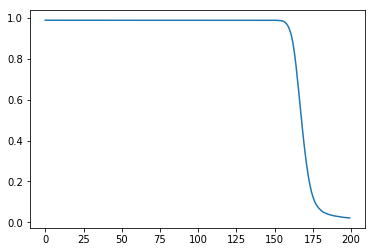

Finished with RBM training of size (1597, 512)
Iteration 0 Error = 1.0021981544182237
Goodness = 16242.273738232298
Iteration 40 Error = 1.0021981544182237
Goodness = 12852.519906223519


In [ ]:
# Pretrain network as a deep belief net (stack restricted Boltzmann machines)

if (0):
    # Uncomment to normalize the input vector? 
    np.mean(X0)
    #X00 = X0
    X0 = X0 / (np.mean(X0) * 2)
    print(np.shape(X0))

if (1):
    # Uncomment to normalize the input vector? 
    # clip words with frequency > 5
    X0[X0>5] = 5
    myMax = np.max(X0)
    X0 = (X0)/myMax # (np.mean(X0) * 2)
    print(np.shape(X0))


t0 = time.time()
trainIt = 200
lR = 3e-3
#rbm13 = trainRBMLayers(a0,14,1e-1,trainIt)
if (1):
    rbm0 = trainRBMLayers(X0,512,lR,trainIt)
    rbm1 = trainRBMLayers(rbm0.T,512,lR,2*trainIt)
    rbm2 = trainRBMLayers(rbm1.T,512,lR,2*trainIt)
    rbm3 = trainRBMLayers(rbm2.T,32,lR,2*trainIt)

elapsed = time.time() - t0
print("Time to train RBMs " + str(elapsed))
elapsed = time.time()-t
print(elapsed)
print(np.shape(rbm0))

In [ ]:
# The stacked RBMS become the layers of a FC neural net

myWeights = []
myWeights.append(rbm0)
myWeights.append(rbm1)
myWeights.append(rbm2)
myWeights.append(rbm3)
myWeights.append(rbm3.T)
myWeights.append(rbm2.T)
myWeights.append(rbm1.T)
myWeights.append(rbm0.T)

for layer in myWeights:
    print("Shape of layer: ", layer.shape)
np.save('./modelParameters/pretrainedWeights',myWeights)



In [353]:
# Train the weights as a neural net 
#for layer in myWeights:
#    print("Shape of weights in layer: ", layer.shape)
#
myWeights = np.load('./modelParameters/pretrainedWeightsShal.npy')
# Does the RBM pre-training help? Run the conditional below to se weights to random initializations
if(0):
    for ck in range(len(myWeights)):
        myWeights[ck] = np.random.random((np.shape(myWeights[ck])))*1e-1

t1 = time.time()
myIt = 1000
myLR = 3e-4
#(myInputs,myCrossInputs,myTarget,myWeights
#,myIter=10,lR=1e-5,myLambda=0,myMom=1e-5,dropout=False):
myNewWeights1 = backProp(X0,X0,myWeights,myIt,myLR,0,0,True)
elapsed = time.time()-t1
print("time to train for" + str(myIt) + " iterations = "+str(elapsed) + " seconds")

Begin Training . . . 
Iteration 0 Mean square error = 0.007639160453720616
Iteration 100 Mean square error = 0.0040002106737101716
Iteration 200 Mean square error = 0.00269571285401033
Iteration 300 Mean square error = 0.001877754451010093
Iteration 400 Mean square error = 0.0015030298289586785
Iteration 500 Mean square error = 0.0012841964177466266
Iteration 600 Mean square error = 0.0011364161299882705
Iteration 700 Mean square error = 0.001029960773259289
Iteration 800 Mean square error = 0.0009500864117609499
Iteration 900 Mean square error = 0.0008883361163059511
time to train for1000 iterations = 27.855876445770264 seconds


(32, 13)


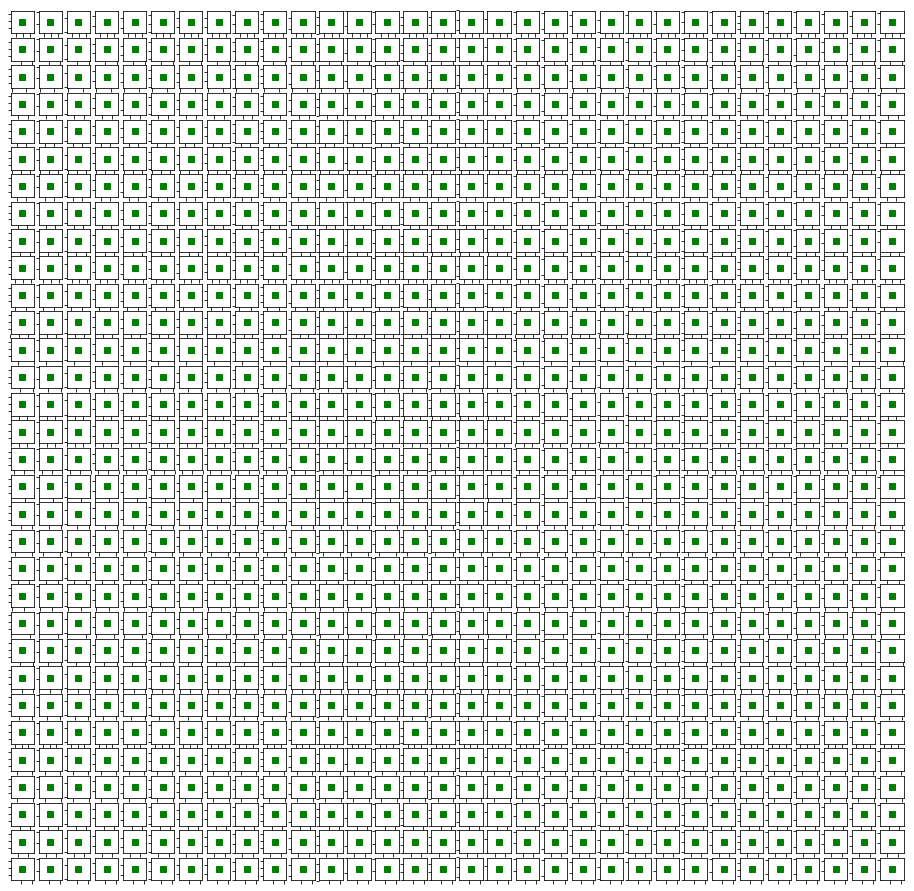

[4.93647553e-05 1.15057381e-04 5.55027719e-05 1.09734407e-04
 5.54217160e-05 3.86951737e-05 7.82977801e-05 9.48299475e-05
 2.29872990e-05 1.02485368e-04 1.29455771e-04 1.48134934e-04
 2.01514871e-05 4.39660755e-05 6.71536284e-05 7.04525487e-05
 2.32915971e-05 4.86544368e-05 8.67182906e-05 9.56685921e-05
 9.88987606e-05 5.61865061e-05 6.18820908e-05 6.61170175e-05
 5.37697943e-05 1.59123116e-04 1.40457743e-04 1.48767207e-04
 4.70507708e-05 4.25891495e-05 5.28252922e-05 3.36117962e-05]


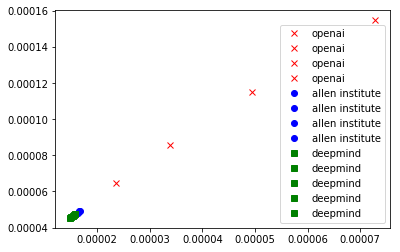

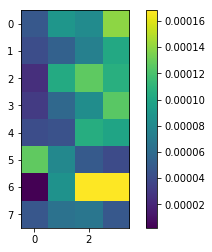

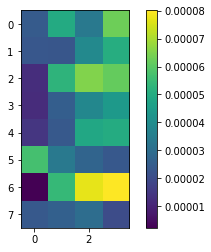

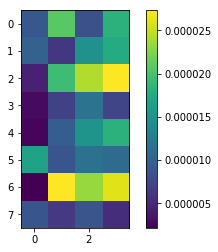

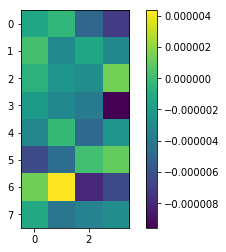

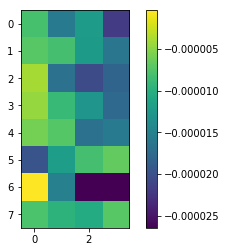

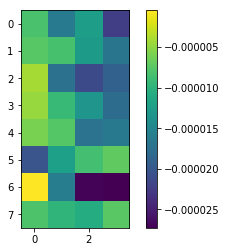

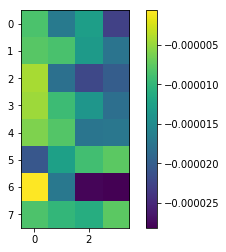

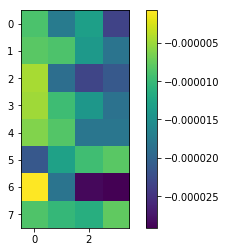

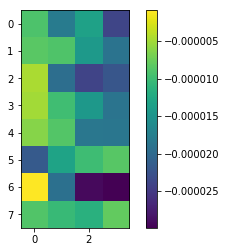

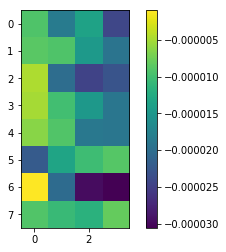

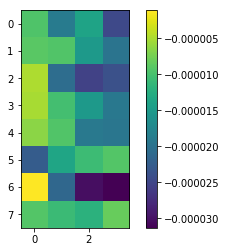

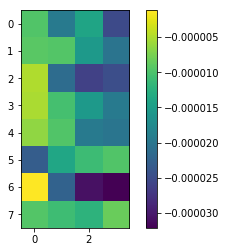

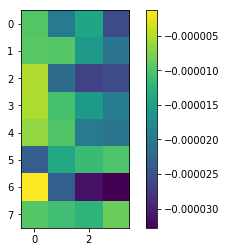

In [371]:


#an,zn = forProp(X0,myWeights)

an,zn = forProp(X0,myNewWeights1)
print(np.shape(an[1][:,:]))

if (1):
    myFig, myAx = plt.subplots(8,8,figsize=(16,16))
    for cx in range(8):
        for cy in range(8):
            if(ck<4):
                myAx[cx,cy].plot(an[1][cx,ck],an[1][cy,ck],'rx',label="openai")       
            elif(ck<8):
                myAx[cx,cy].plot(an[1][cx,ck],an[1][cy,ck],'bo',label="allen institute")
            else:
                myAx[cx,cy].plot(an[1][cx,ck],an[1][cy,ck],'gs',label="deepmind")
            myAx[cx,cy].set_xticklabels([])
            myAx[cx,cy].set_yticklabels([])
            #myAx[cx,cy].plot(an[1][cx,cx].T,an[1][:,cy].T,'o')
plt.show()
plt.figure()
for ck in range(13):
    if(ck<4):
        plt.plot(an[1][0,ck],an[1][1,ck],'rx',label="openai")       
    elif(ck<8):
        plt.plot(an[1][0,ck],an[1][1,ck],'bo',label="allen institute")
    else:
        plt.plot(an[1][0,ck],an[1][1,ck],'gs',label="deepmind")
    plt.legend()
print(an[1][:,1])
for ck in range(13):
    plt.figure()
    
    plt.imshow(np.reshape(an[1][:,ck]-np.mean(an[1][:,:],axis=1),(8,4)))
    plt.colorbar()
    plt.show()

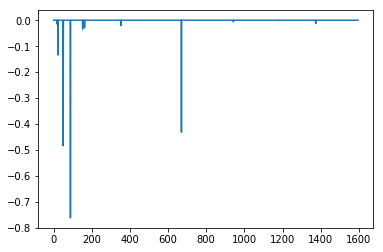

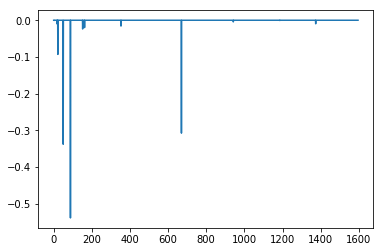

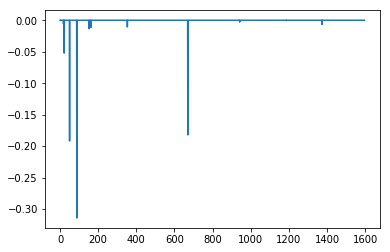

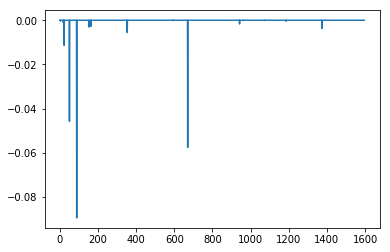

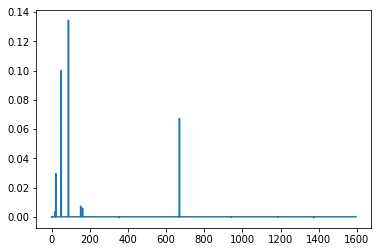

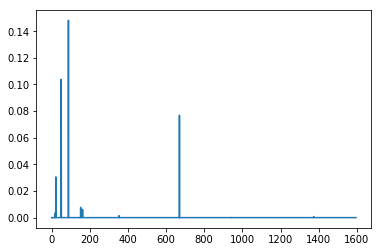

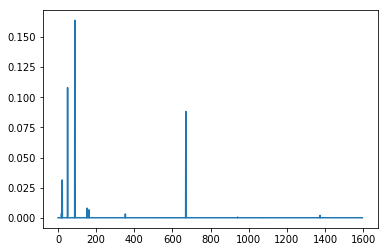

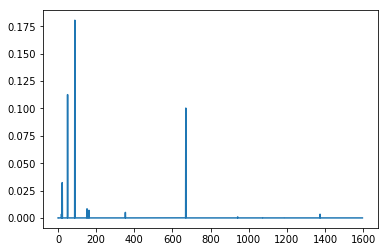

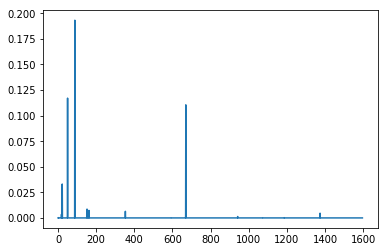

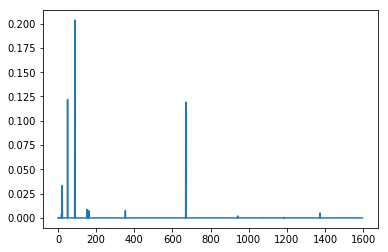

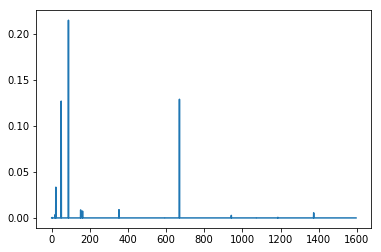

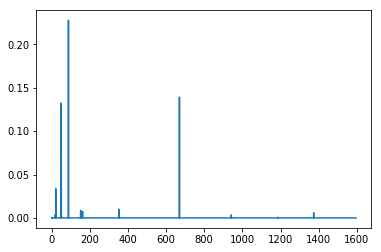

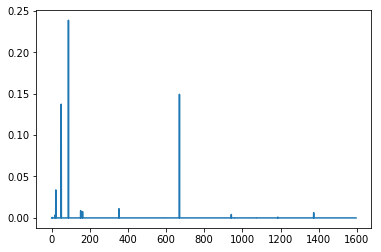

In [355]:
for ck in range(13):
    plt.figure()
    plt.plot(X0[:,ck]-np.mean(X0,axis=1))
    #plt.figure()
    #plt.plot(np.mean(X0,axis=1))
    plt.show()

In [6]:
"""Data"""
"""
sources: 
https://blog.openai.com/welcome-pieter-and-shivon/
https://blog.openai.com/team-plus-plus/
https://blog.openai.com/team-update-january/
https://blog.openai.com/team-update/
https://blog.openai.com/team-update-august/

Out groups:
https://en.wikipedia.org/wiki/Sonic_the_Hedgehog
https://wiki.kerbalspaceprogram.com/wiki/Jebediah_Kerman
https://en.wikipedia.org/wiki/Luigi
https://en.wikipedia.org/wiki/Saiga_antelope
https://en.wikipedia.org/wiki/Mario
"""

outgroup = np.load('./data/outgroup.npy')
openaiFulltime = np.load('./data/openAIFullTimeBios.npy')
openaiInterns = np.load('./data/openAIInternBios.npy')

myBios = ["Rive Sunder is a bipedal primate with the demonstrated ability to occasionally put two\
        sticks together. to make and manipulate tools, including tools that have the same ability. They have worked on inverse problems in \ 
          microscopy. Whilst knee-high to a duck, Rive won the national science olympiad  "]


In [4]:
# convert bios to BOWs
wordcount = {}
weirdChar = [',','.','?','!','[','{',']','}',':',';','%','/','/','+','=']

#clean words of punctuation
for shortBios in [openaiFulltime, openaiInterns,myBios,outgroup]:
    for shortBio in shortBios:
        for word in shortBio.split():
            doAdd = 1
            
                
            if word not in wordcount:
                wordcount[word] = 1
            else:
                wordcount[word] += 1
                
print("%i intern bios, %i  full-time bios"%(len(openaiInterns),len(openaiFulltime)))
print("The dictionary for short bios is %i words long (before cleaning)"%len(wordcount))
        
def text_to_BOW(text,wordcount):
    """Generate Bag-of-Words vector for text list based on available words in wordcount"""
    weirdChar = [',','.','?','!','[','{',']','}',':',';','%','/','/','+','=',\
                "by","which","with","and", "a", "in", "is", "to", "of", "on", "the", "at", "has", "from", "for", "an","In",]

    # build wordcounting dictionary            
    bowDict = {}
    for word in wordcount:
        newWord = word
        for wChar in weirdChar:
            newWord = newWord.replace(wChar,"")
        bowDict[newWord] = 0  
    
    # count word frequency
    myBOWVec = np.array([[0],[0]])
    for entry in text:
        myTemp = bowDict
        for word in entry.split():
            if word in myTemp:
                #print(word)
                myTemp[word] += 1
                
        X = np.array([[1]])

        for k,v in myTemp.items():
            #print(k,v)
            X = np.append(X,[[v]],1)
        X = X[:,1:(X.shape[1])]
        if (len((myBOWVec[0])) > 1):
            myBOWVec = (np.append(myBOWVec,X,0))
        else: 
            #init first entry if output vector is None
            myBOWVec = X
    return myBOWVec, bowDict

NameError: name 'openaiFulltime' is not defined

(963,)
(963,)
(963,)


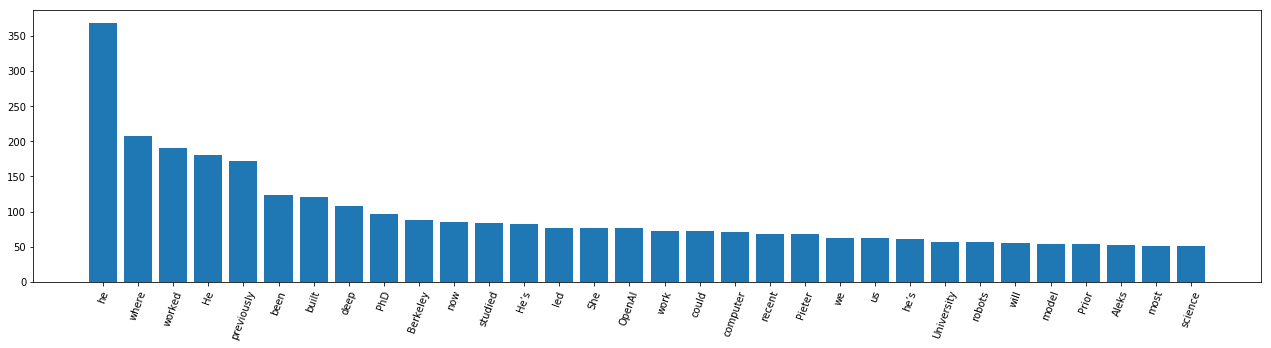

In [365]:
plt.figure(figsize=(22,5))

mySortOrder = np.argsort(np.sum(ftVecs,axis=0))[::-1]
myTest = np.take(np.sum(ftVecs,axis=0),mySortOrder,0)
print(np.shape(mySortOrder))

myKeys = list(myBowDict.keys())
print(np.shape(myKeys))
myTest2 = np.take(myKeys,mySortOrder,0)

print(np.shape(myTest))
plt.bar(range(len(outVecs[0,0:32])), myTest[0:32], align='center')

plt.xticks(range(len(outVecs[0,0:32])), myTest2,rotation=70)

plt.show()

In [398]:
myBios = ["Rive Sunder "]

In [399]:
#for entry in openaiInterns:
#    print(entry.split())

internVecs, myBowDict = text_to_BOW(openaiInterns,wordcount)
ftVecs, myBowDict = text_to_BOW(openaiFulltime,wordcount)
myVecs, myBowDict = text_to_BOW(myBios,wordcount)

outVecs, myBowDict = text_to_BOW(outgroup,wordcount)

noInterns = len(internVecs)
noFT = len(ftVecs)
noMyBios = len(myVecs)
allBioVecs = np.append(internVecs,ftVecs,axis=0)
allBioVecs = np.append(allBioVecs,myVecs,axis=0)
allBioVecs = np.append(allBioVecs,outVecs,axis=0)

In [5]:
if(1):
    myFile = open("./allOpenAIBios.txt",'w')
    for shortBios in [openaiFulltime, openaiInterns]:
        for shortBio in shortBios:
            myFile.write(shortBio)
    myFile.close()

In [3]:
"""Data"""

# short bios manually scraped from openAI website. 
# short bios of full-timers
openaiFulltime = ['Pieter is a professor at UC Berkeley specializing in making robots learn. He’s been giving us advice since before OpenAI was born, and now he’s taking a leave from Berkeley to work with us full-time. Pieter and his lab members have been responsible for some of the most striking advances in robot learning and deep reinforcement learning (RL) in recent years. Together, we will explore ways to combine unsupervised learning with RL, which we believe could address fundamental limitations in today’s RL algorithms. ',\
                'Shivon is a partner at Bloomberg Beta focusing on machine intelligence. She has an extremely broad view of how the space is evolving (and has written extensively on the landscape). We’ve been going to her for advice for the past few months, and now she’s becoming an official advisor to OpenAI. ',\
                'Yura finished a math PhD at the age of 24, and switched into machine learning a year and a half ago. He’s focusing on generative models. He discovered a simple but fundamental improvement to the variational lower bound that had evaded notice since its original discovery decades ago.',\
                'Ian is well known for his many contributions to machine learning, including the MaxOut Network and the Generative Adversarial Network, the latter of which is a driver of excitement in generative modeling research. In addition, he’s the lead author of the book on deep learning.',\
                'Alec created DCGAN, a neural model that could generate large, coherent images containing an unprecedented level of global coherence and detail. In addition, his model has learned to do image analogies in an entirely unsupervised way.',\
                'Aleks is a recent graduate from Berkeley where he did research on distributed machine learning and taught Data Structures and Operating Systems for 2 years. Previously, Aleks was an intern at Stripe working on the Financial Operations team.',\
                'Alex previously built radio encryption systems for small satellites at Planet Labs. Prior to that he worked on aerial robots at Airware. He has a degree in Textile Engineering from NCSU, where he worked on a design for an inflatable habitat for living on Mars.',\
                'Ankur obtained his PhD in real-time camera tracking at Imperial College London, then became a post-doc at the University of Cambridge to focus on scene understanding via his work on SceneNet. He returned to Imperial as a Dyson Fellow to continue his research on scene understanding with SceneNet RGB-D. His interests lie at the intersection of hardware, SLAM, and deep learning.',\
                'Bob formerly led engineering and product management at Palantir, having worked there for a decade as it grew from 10 to 1,500 employees. Before Palantir, Bob was a PhD candidate in the Stanford Artificial Intelligence Lab working on multiagent systems. At OpenAI, he focuses on robotics.',\
                'Christopher was previously an engineer at Facebook, where he worked on Presto, an open-source distributed SQL engine. He led the data warehouse deployment of Presto, and scaled it to hundreds of petabytes of data. In his spare time, he builds quadrotors and created Rospilot, an autopilot companion system that provides real-time video streaming and other features, using commodity hardware.',\
                'Erika was previously the Director of Product Engineering at Planet Labs, where she spent the last four years building teams and software to support collecting and distributing high-frequency satellite imagery, ranging from mission control and manufacturing management, to image processing and platform design. She studied mechanical engineering and computer science at MIT. As OpenAI’s Engineering Director, Erika will help manage and grow the team.',\
                'Jakub recently finished a PhD at CMU where he worked on the theory of optimization. He co-invented the fastest known algorithms for solving linear systems on graphs and computing the geometric median. In the past, Jakub was a top competitive programmer, and has won the Google Code Jam and gained a gold medal in the ACM-ICPC.',\
                'Jeremy is an engineer who previously worked at Mailgun and Google. Since joining OpenAI he has built the tight encoding implementation for OpenAI Universe’s go-vncdriver and tools for collecting human demonstrations of Universe environments.',\
                'Jonathan previously built a peer-to-peer file sync tool at AeroFS, and was an early engineer at Magic, an SMS-based virtual personal assistant. Prior to that, he studied Electrical & Computer Engineering at the University of Toronto. In high school and during his undergrad, he built software for cancer treatment at Sunnybrook Research Institute’s Focused Ultrasound Group.',\
                'Peter was an engineering lead at Dropbox, where he led the photos infrastructure, computer vision, and machine learning teams. Before that, he co-founded AI startup Anchovi Labs and did his graduate work at Caltech in computer vision and crowd sourcing.',\
                'Rachel most recently worked on data engineering at Locu. In the past she’s designed robots, and built a haptic surgical simulator, a $50 desktop 3D scanner, and an NLP backend to extract data from uploaded documents to create personalized curriculums for learning language. She studied computer science at MIT',\
                'Shariq founded an OCR startup, and previously worked at Gigster. He also builds DIY projects, like a $80 VR treadmill, a portable shower, and a device to control a mouse cursor with a tongue. He studied Computer Science and Electrical Engineering at the University of Maryland, where he founded a hackathon club which won the first-ever Major League Hacking season.',\
                'Tom was the cofounder and CTO of Grouper, where he wrote algorithms that used Facebook data to match up millions of people so they could meet in the real world. Before that he studied computational cognitive science at MIT, and built early versions of the core server at MoPub, now the world’s largest mobile ad server.',\
                'Szymon previously worked on model-based reinforcement learning at Vicarious, question answering at MetaMind, and on real-time file processing infrastructure at Dropbox. He earned his master’s degree from MIT, where he explored reinforcement learning approaches to multi-stage reasoning in natural language processing, and identified security flaws in Android.',\
                'Yaroslav was previously an engineer at Google Brain and Google Streetview, where he implemented and trained large-scale neural networks. He designed the first system that outperformed humans at recognizing outdoor house numbers.',\
                'Marcin received 3 gold medals in the IOI, and has been a top participant in programming competitions such as TopCoder and ACM-ICPC. He’s been in deep learning for a year and has already made strong progress on neural memory architectures.',\
                'Rafał began his career in competitive programming and the finance industry. He’s now been in deep learning for a year and a half, and his results include the state-of-the-art language model.',\
                'Kate has a versatile background, with experience across operations, office administration, user research, community, and support. She previously helped Academia.edu run smoothly.',\
                'Ludwig was previously Stripe’s Creative Director, where he built and led the design team.',\
                'Jonas did much of the engineering heavy lifting on OpenAI Gym. A recent college graduate, he was previously an intern at Stripe, where he helped build Stripe CTF3.',\
                'Jie was an engineer at Dropbox for almost five years, where he led the team responsible for the core file sync technology running on hundreds of millions of desktops. Prior to that he worked in Pieter Abbeel’s robotics lab at Berkeley, working on autonomous helicopters, RGBD perception, and Starcraft bots.',\
                'Dario was one of the lead authors of Deep Speech 2, a speech system which achieved near-human performance on many speech tasks. He is also a main co-author of “Concrete Problems in AI Safety”, which highlights issues related to accidents in machine learning systems. Prior to OpenAI, he worked at Google Brain.',\
                'Filip’s recent background is in “practical” modeling, having spent the last few years working in the high-frequency trading space. In the past he enjoyed problem-solving in programming competitions, and won the IOI and ACM ICPC.',\
                'Jack has spent the past few years writing about artificial intelligence and distributed systems, most recently at Bloomberg and BusinessWeek. His articles have covered technologies like memory networks, image generation, and reinforcement learning for robots, and issues like diversity within AI. As our Strategy and Communications Director, he will help with community outreach, policy, communications, and strategy.',\
                'Scott was previously an engineer at Nervana Systems where he focused on optimizing the performance of deep networks on GPUs. His assembly-level optimizations for dense linear algebra and convolution remain the fastest available. When not writing software he’s usually spending his time reading up on the latest research in neuroscience and related fields.',\
                'Zain previously led deep learning efforts to build a collaborative human-machine intelligence system at Clara Labs. He’s also worked on speech synthesis and computational neuroscience, built Mosaic, and founded a mobile behavioral analytics company. He most recently built a GIF search engine using deep multimodal embeddings.'\
                 ]

# bios of interns/visitors
openaiInterns = ['Catherine built OpenAI Gym’s REST API, which has already attracted users in Lua, C++, Java, and Rust. She graduated with a perfect GPA in CS and Brain & Cognitive Science from MIT, and has extensive research experience in computational neuroscience and psychology. Catherine has taught programming and applied math for six years, including outreach to women and underrepresented minorities.',\
                'Harri is a PhD student at the University of Edinburgh, where he is researching models that can quickly adapt to new situations by learning to represent datasets.',\
                'Igor is interested in optimal control, machine learning, and their applications to robotics, biomechanics, and neuroscience. His PhD was in automated discovery and learning of complex movement behaviors. He will join the faculty at CMU in September 2017.',\
                'Taco is a PhD student working on applied and theoretical problems in representation learning. Most recently he invented group equivariant convolutional neural networks (G-CNNs), a generalization of CNNs that improves the statistical efficiency of these models by exploiting symmetries.',\
                'Tambet is a PhD student from University of Tartu, Estonia. He previously worked as a software engineer and founded his own startup. His recent projects range from making deep reinforcement learning agents cooperate to predicting a rat’s location from its brain activity. He also wrote an accessible introduction to deep Q-learning.',\
                'Prafulla was a gold medalist in the IMO, IPhO, and IAO. He’s currently an undergraduate at MIT, performing research on learning of invariant representations for speech and vision tasks.',\
                'Paul is a PhD student at Berkeley who has written extensively about AI safety. He received best paper and best student paper awards at STOC for research on optimization and online learning.',\
                'Tim is an expert on variational methods. The author of the first paper on stochastic gradient variational inference (for which he won the Lindley prize), he was at one point ranked number 2 overall on Kaggle.',\
                'Peter previously co-founded a startup and did research on parallel computing and cognitive science. Recently, he’s been working on reinforcement learning, from theory to applications with deep neural nets.',\
                'Rocky is a PhD student who previously co-founded a startup (with Peter) and worked on a number of projects in robotics. He’s now transitioned to the field of deep reinforcement learning, and recently TA’d Berkeley’s Deep Reinforcement Learning class.',\
                'Although Linxi is just finishing up his undergrad, he has already worked on a variety of projects in deep learning, including Deep Speech 2.',\
                'Jon is an undergraduate student whose achievements include, among others, a method that makes it possible to efficiently train large recursive neural networks on large datasets.',\
                'Jonathan is a PhD student at Stanford, where he is developing a new approach to imitation learning. Earlier in his research career, he had success teaching robots how to tie knots.',\
                'Rein hails from Belgium, started his research career in the field of computer networking, and now is developing novel ways to incorporate uncertainty into deep reinforcement learning algorithms.',\
                'Eric is a professor of theoretical computer science at UT Austin. His achievements include the development and the analysis of a faster-than-n log n sparse Fourier transform. In his past life, he achieved a perfect score at the IOI.'\
                ]

outgroup = ["Jebediah is one of the original four kerbonauts,\
            along with Bill, Bob, and Valentina who wear the orange jump suits \
            instead of the customary grey ones. He is the only default male kerbal \
            with the attribute badS = True. Short for 'badass', this makes Jeb's \
            facial expression and general reaction be 'happy'' ones in almost all\
            situations which might trigger 'afraid'' reactions in the typical kerbonaut. \
            Whatever effect his dead-middle ratings for Courage and Stupidity would \
            have on personality are overridden by his sheer badassery. Valentina Kerman \
            is often considered a female equivalent to Jebediah Kerman and also has the badS = \
            True attribute,the two are the only default kerbals with the badS flag.",\
            "Mario is a fictional character in the Mario video game franchise, owned by Nintendo and created by Japanese video game designer Shigeru Miyamoto. Serving as the company's mascot and the eponymous protagonist of the series, Mario has appeared in over 200 video games since his creation. Depicted as a short, pudgy, Italian plumber who resides in the Mushroom Kingdom, his adventures generally center upon rescuing Princess Peach from the Koopa villain Bowser. His younger brother and sidekick is Luigi.",\
            "Luigi is a fictional character featured in video games and related media released by Nintendo. Created by prominent game designer Shigeru Miyamoto, Luigi is portrayed as the slightly younger but taller fraternal twin brother of Nintendo's mascot Mario, and appears in many games throughout the Mario franchise, often as a sidekick to his brother.",\
            "The saiga antelope is a critically endangered antelope that originally inhabited a vast area of the Eurasian steppe zone from the foothills of the Carpathian Mountains and Caucasus into Dzungaria and Mongolia.",\
            "Sonic, the protagonist, is an anthropomorphic blue hedgehog with supersonic speed, capable of reaching the speed of sound. Typically, Sonic—usually along with some of his friends, such as Tails, Amy, and Knuckles—must stop antagonist Doctor Eggman's plans for world domination."\
           ]


np.save('./data/openAIFullTimeBios.npy',openaiFulltime)
np.save('./data/openAIInternBios.npy',openaiInterns)
np.save('./data/outgroup.npy',outgroup)

In [400]:
import sklearn
from sklearn.manifold import TSNE

mySeed = 42
myModel2d = TSNE(n_components=2,random_state=mySeed)#,init='pca')
myModel3d = TSNE(n_components=3,random_state=mySeed)#,init='pca')
bios2d = myModel2d.fit_transform(allBioVecs)
bios3d = myModel3d.fit_transform(allBioVecs)



from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


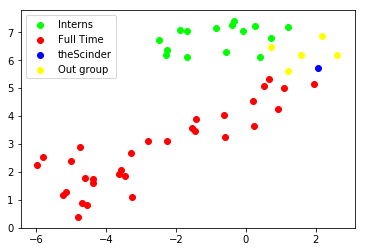

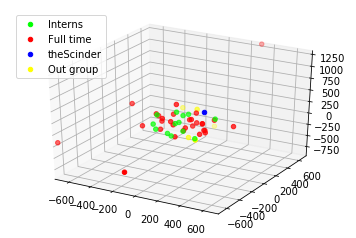

In [401]:
fig2d = plt.figure()

ax2d = fig2d.add_subplot(111)
ax2d.scatter(bios2d[0:noInterns,0],bios2d[0:noInterns,1],color=[0,1,0],label="Interns")
ax2d.scatter(bios2d[noInterns:noFT+noInterns,0],bios2d[noInterns:noFT+noInterns,1],color=[1,0,0],label="Full Time")
ax2d.scatter(bios2d[noFT+noInterns:noFT+noInterns+noMyBios,0],bios2d[noFT+noInterns:noFT+noInterns+noMyBios,1],color=[0,0,1],label="theScinder")
ax2d.scatter(bios2d[noFT+noInterns+noMyBios:len(bios2d),0],bios2d[noFT+noInterns+noMyBios:len(bios2d),1],color=[1,1,0],label="Out group")

ax2d.legend()

axLimits = 700

fig3d = plt.figure()
ax3d = fig3d.add_subplot(111, projection='3d')

ax3d.scatter(bios3d[0:noInterns,0],bios3d[0:noInterns,1],bios3d[0:noInterns,2],color=[0,1,0],label="Interns")
ax3d.scatter(bios3d[noInterns:noFT+noInterns,0],bios3d[noInterns:noFT+noInterns,1],bios3d[noInterns:noFT+noInterns,2],color=[1,0,0],label="Full time")
ax3d.scatter(bios3d[noFT+noInterns:noFT+noInterns+noMyBios,0],bios3d[noFT+noInterns:noFT+noInterns+noMyBios,1],bios3d[noFT+noInterns:noFT+noInterns+noMyBios,2],color=[0,0,1],label="theScinder")
ax3d.scatter(bios3d[noFT+noInterns+noMyBios:len(bios3d),0],bios3d[noFT+noInterns+noMyBios:len(bios3d),1],bios3d[noFT+noInterns+noMyBios:len(bios3d),2],color=[1,1,0],label="Out group")
ax3d.axis([-axLimits,axLimits,-axLimits,axLimits])
ax3d.legend()
plt.show()

In [397]:
help(TSNE)

Help on class TSNE in module sklearn.manifold.t_sne:

class TSNE(sklearn.base.BaseEstimator)
 |  t-distributed Stochastic Neighbor Embedding.
 |  
 |  t-SNE [1] is a tool to visualize high-dimensional data. It converts
 |  similarities between data points to joint probabilities and tries
 |  to minimize the Kullback-Leibler divergence between the joint
 |  probabilities of the low-dimensional embedding and the
 |  high-dimensional data. t-SNE has a cost function that is not convex,
 |  i.e. with different initializations we can get different results.
 |  
 |  It is highly recommended to use another dimensionality reduction
 |  method (e.g. PCA for dense data or TruncatedSVD for sparse data)
 |  to reduce the number of dimensions to a reasonable amount (e.g. 50)
 |  if the number of features is very high. This will suppress some
 |  noise and speed up the computation of pairwise distances between
 |  samples. For more tips see Laurens van der Maaten's FAQ [2].
 |  
 |  Read more in the 

In [1]:
"""Data"""

# short bios manually scraped from openAI website. 
# short bios of full-timers
openaiFulltime = ['Pieter is a professor at UC Berkeley specializing in making robots learn. He’s been giving us advice since before OpenAI was born, and now he’s taking a leave from Berkeley to work with us full-time. Pieter and his lab members have been responsible for some of the most striking advances in robot learning and deep reinforcement learning (RL) in recent years. Together, we will explore ways to combine unsupervised learning with RL, which we believe could address fundamental limitations in today’s RL algorithms. ',\
                'Shivon is a partner at Bloomberg Beta focusing on machine intelligence. She has an extremely broad view of how the space is evolving (and has written extensively on the landscape). We’ve been going to her for advice for the past few months, and now she’s becoming an official advisor to OpenAI. ',\
                'Yura finished a math PhD at the age of 24, and switched into machine learning a year and a half ago. He’s focusing on generative models. He discovered a simple but fundamental improvement to the variational lower bound that had evaded notice since its original discovery decades ago.',\
                'Ian is well known for his many contributions to machine learning, including the MaxOut Network and the Generative Adversarial Network, the latter of which is a driver of excitement in generative modeling research. In addition, he’s the lead author of the book on deep learning.',\
                'Alec created DCGAN, a neural model that could generate large, coherent images containing an unprecedented level of global coherence and detail. In addition, his model has learned to do image analogies in an entirely unsupervised way.',\
                'Aleks is a recent graduate from Berkeley where he did research on distributed machine learning and taught Data Structures and Operating Systems for 2 years. Previously, Aleks was an intern at Stripe working on the Financial Operations team.',\
                'Alex previously built radio encryption systems for small satellites at Planet Labs. Prior to that he worked on aerial robots at Airware. He has a degree in Textile Engineering from NCSU, where he worked on a design for an inflatable habitat for living on Mars.',\
                'Ankur obtained his PhD in real-time camera tracking at Imperial College London, then became a post-doc at the University of Cambridge to focus on scene understanding via his work on SceneNet. He returned to Imperial as a Dyson Fellow to continue his research on scene understanding with SceneNet RGB-D. His interests lie at the intersection of hardware, SLAM, and deep learning.',\
                'Bob formerly led engineering and product management at Palantir, having worked there for a decade as it grew from 10 to 1,500 employees. Before Palantir, Bob was a PhD candidate in the Stanford Artificial Intelligence Lab working on multiagent systems. At OpenAI, he focuses on robotics.',\
                'Christopher was previously an engineer at Facebook, where he worked on Presto, an open-source distributed SQL engine. He led the data warehouse deployment of Presto, and scaled it to hundreds of petabytes of data. In his spare time, he builds quadrotors and created Rospilot, an autopilot companion system that provides real-time video streaming and other features, using commodity hardware.',\
                'Erika was previously the Director of Product Engineering at Planet Labs, where she spent the last four years building teams and software to support collecting and distributing high-frequency satellite imagery, ranging from mission control and manufacturing management, to image processing and platform design. She studied mechanical engineering and computer science at MIT. As OpenAI’s Engineering Director, Erika will help manage and grow the team.',\
                'Jakub recently finished a PhD at CMU where he worked on the theory of optimization. He co-invented the fastest known algorithms for solving linear systems on graphs and computing the geometric median. In the past, Jakub was a top competitive programmer, and has won the Google Code Jam and gained a gold medal in the ACM-ICPC.',\
                'Jeremy is an engineer who previously worked at Mailgun and Google. Since joining OpenAI he has built the tight encoding implementation for OpenAI Universe’s go-vncdriver and tools for collecting human demonstrations of Universe environments.',\
                'Jonathan previously built a peer-to-peer file sync tool at AeroFS, and was an early engineer at Magic, an SMS-based virtual personal assistant. Prior to that, he studied Electrical & Computer Engineering at the University of Toronto. In high school and during his undergrad, he built software for cancer treatment at Sunnybrook Research Institute’s Focused Ultrasound Group.',\
                'Peter was an engineering lead at Dropbox, where he led the photos infrastructure, computer vision, and machine learning teams. Before that, he co-founded AI startup Anchovi Labs and did his graduate work at Caltech in computer vision and crowd sourcing.',\
                'Rachel most recently worked on data engineering at Locu. In the past she’s designed robots, and built a haptic surgical simulator, a $50 desktop 3D scanner, and an NLP backend to extract data from uploaded documents to create personalized curriculums for learning language. She studied computer science at MIT',\
                'Shariq founded an OCR startup, and previously worked at Gigster. He also builds DIY projects, like a $80 VR treadmill, a portable shower, and a device to control a mouse cursor with a tongue. He studied Computer Science and Electrical Engineering at the University of Maryland, where he founded a hackathon club which won the first-ever Major League Hacking season.',\
                'Tom was the cofounder and CTO of Grouper, where he wrote algorithms that used Facebook data to match up millions of people so they could meet in the real world. Before that he studied computational cognitive science at MIT, and built early versions of the core server at MoPub, now the world’s largest mobile ad server.',\
                'Szymon previously worked on model-based reinforcement learning at Vicarious, question answering at MetaMind, and on real-time file processing infrastructure at Dropbox. He earned his master’s degree from MIT, where he explored reinforcement learning approaches to multi-stage reasoning in natural language processing, and identified security flaws in Android.',\
                'Yaroslav was previously an engineer at Google Brain and Google Streetview, where he implemented and trained large-scale neural networks. He designed the first system that outperformed humans at recognizing outdoor house numbers.',\
                'Marcin received 3 gold medals in the IOI, and has been a top participant in programming competitions such as TopCoder and ACM-ICPC. He’s been in deep learning for a year and has already made strong progress on neural memory architectures.',\
                'Rafał began his career in competitive programming and the finance industry. He’s now been in deep learning for a year and a half, and his results include the state-of-the-art language model.',\
                'Kate has a versatile background, with experience across operations, office administration, user research, community, and support. She previously helped Academia.edu run smoothly.',\
                'Ludwig was previously Stripe’s Creative Director, where he built and led the design team.',\
                'Jonas did much of the engineering heavy lifting on OpenAI Gym. A recent college graduate, he was previously an intern at Stripe, where he helped build Stripe CTF3.',\
                'Jie was an engineer at Dropbox for almost five years, where he led the team responsible for the core file sync technology running on hundreds of millions of desktops. Prior to that he worked in Pieter Abbeel’s robotics lab at Berkeley, working on autonomous helicopters, RGBD perception, and Starcraft bots.',\
                'Dario was one of the lead authors of Deep Speech 2, a speech system which achieved near-human performance on many speech tasks. He is also a main co-author of “Concrete Problems in AI Safety”, which highlights issues related to accidents in machine learning systems. Prior to OpenAI, he worked at Google Brain.',\
                'Filip’s recent background is in “practical” modeling, having spent the last few years working in the high-frequency trading space. In the past he enjoyed problem-solving in programming competitions, and won the IOI and ACM ICPC.',\
                'Jack has spent the past few years writing about artificial intelligence and distributed systems, most recently at Bloomberg and BusinessWeek. His articles have covered technologies like memory networks, image generation, and reinforcement learning for robots, and issues like diversity within AI. As our Strategy and Communications Director, he will help with community outreach, policy, communications, and strategy.',\
                'Scott was previously an engineer at Nervana Systems where he focused on optimizing the performance of deep networks on GPUs. His assembly-level optimizations for dense linear algebra and convolution remain the fastest available. When not writing software he’s usually spending his time reading up on the latest research in neuroscience and related fields.',\
                'Zain previously led deep learning efforts to build a collaborative human-machine intelligence system at Clara Labs. He’s also worked on speech synthesis and computational neuroscience, built Mosaic, and founded a mobile behavioral analytics company. He most recently built a GIF search engine using deep multimodal embeddings.'\
                 ]

# bios of interns/visitors
openaiInterns = ['Catherine built OpenAI Gym’s REST API, which has already attracted users in Lua, C++, Java, and Rust. She graduated with a perfect GPA in CS and Brain & Cognitive Science from MIT, and has extensive research experience in computational neuroscience and psychology. Catherine has taught programming and applied math for six years, including outreach to women and underrepresented minorities.',\
                'Harri is a PhD student at the University of Edinburgh, where he is researching models that can quickly adapt to new situations by learning to represent datasets.',\
                'Igor is interested in optimal control, machine learning, and their applications to robotics, biomechanics, and neuroscience. His PhD was in automated discovery and learning of complex movement behaviors. He will join the faculty at CMU in September 2017.',\
                'Taco is a PhD student working on applied and theoretical problems in representation learning. Most recently he invented group equivariant convolutional neural networks (G-CNNs), a generalization of CNNs that improves the statistical efficiency of these models by exploiting symmetries.',\
                'Tambet is a PhD student from University of Tartu, Estonia. He previously worked as a software engineer and founded his own startup. His recent projects range from making deep reinforcement learning agents cooperate to predicting a rat’s location from its brain activity. He also wrote an accessible introduction to deep Q-learning.',\
                'Prafulla was a gold medalist in the IMO, IPhO, and IAO. He’s currently an undergraduate at MIT, performing research on learning of invariant representations for speech and vision tasks.',\
                'Paul is a PhD student at Berkeley who has written extensively about AI safety. He received best paper and best student paper awards at STOC for research on optimization and online learning.',\
                'Tim is an expert on variational methods. The author of the first paper on stochastic gradient variational inference (for which he won the Lindley prize), he was at one point ranked number 2 overall on Kaggle.',\
                'Peter previously co-founded a startup and did research on parallel computing and cognitive science. Recently, he’s been working on reinforcement learning, from theory to applications with deep neural nets.',\
                'Rocky is a PhD student who previously co-founded a startup (with Peter) and worked on a number of projects in robotics. He’s now transitioned to the field of deep reinforcement learning, and recently TA’d Berkeley’s Deep Reinforcement Learning class.',\
                'Although Linxi is just finishing up his undergrad, he has already worked on a variety of projects in deep learning, including Deep Speech 2.',\
                'Jon is an undergraduate student whose achievements include, among others, a method that makes it possible to efficiently train large recursive neural networks on large datasets.',\
                'Jonathan is a PhD student at Stanford, where he is developing a new approach to imitation learning. Earlier in his research career, he had success teaching robots how to tie knots.',\
                'Rein hails from Belgium, started his research career in the field of computer networking, and now is developing novel ways to incorporate uncertainty into deep reinforcement learning algorithms.',\
                'Eric is a professor of theoretical computer science at UT Austin. His achievements include the development and the analysis of a faster-than-n log n sparse Fourier transform. In his past life, he achieved a perfect score at the IOI.'\
                ]
myBios = ["theScinder has achievements from developing computer science,and previously co-founded the start-up that built the algorithm. He has writtern about research in theoretical problems and is interested in applications in learning AI safety and neuroscience",\
          "theScinder became interested in inverse problems in microscopy as a way to get closer \
          to neuroscience, studied biophysics instead. He has worked on projects for unsupervised learning of forward/inverse problems\
          and learning colors from grayscale images with chromatic aberrations to test theories about chromatic vision \
          in cephalopods (that do not have color photoreceptors)."
         ]

outgroup = ["Jebediah is one of the original four kerbonauts,\
            along with Bill, Bob, and Valentina who wear the orange jump suits \
            instead of the customary grey ones. He is the only default male kerbal \
            with the attribute badS = True. Short for 'badass', this makes Jeb's \
            facial expression and general reaction be 'happy'' ones in almost all\
            situations which might trigger 'afraid'' reactions in the typical kerbonaut. \
            Whatever effect his dead-middle ratings for Courage and Stupidity would \
            have on personality are overridden by his sheer badassery. Valentina Kerman \
            is often considered a female equivalent to Jebediah Kerman and also has the badS = \
            True attribute,the two are the only default kerbals with the badS flag.",\
            "Mario is a fictional character in the Mario video game franchise, owned by Nintendo and created by Japanese video game designer Shigeru Miyamoto. Serving as the company's mascot and the eponymous protagonist of the series, Mario has appeared in over 200 video games since his creation. Depicted as a short, pudgy, Italian plumber who resides in the Mushroom Kingdom, his adventures generally center upon rescuing Princess Peach from the Koopa villain Bowser. His younger brother and sidekick is Luigi.",\
            "Luigi is a fictional character featured in video games and related media released by Nintendo. Created by prominent game designer Shigeru Miyamoto, Luigi is portrayed as the slightly younger but taller fraternal twin brother of Nintendo's mascot Mario, and appears in many games throughout the Mario franchise, often as a sidekick to his brother.",\
            "The saiga antelope is a critically endangered antelope that originally inhabited a vast area of the Eurasian steppe zone from the foothills of the Carpathian Mountains and Caucasus into Dzungaria and Mongolia.",\
            "Sonic, the protagonist, is an anthropomorphic blue hedgehog with supersonic speed, capable of reaching the speed of sound. Typically, Sonic—usually along with some of his friends, such as Tails, Amy, and Knuckles—must stop antagonist Doctor Eggman's plans for world domination."\
           ]

"""
sources: 
https://blog.openai.com/welcome-pieter-and-shivon/
https://blog.openai.com/team-plus-plus/
https://blog.openai.com/team-update-january/
https://blog.openai.com/team-update/
https://blog.openai.com/team-update-august/
https://en.wikipedia.org/wiki/Sonic_the_Hedgehog
"""

# convert bios to BOWs
wordcount = {}
weirdChar = [',','.','?','!','[','{',']','}',':',';','%','/','/','+','=']

#clean words of punctuation
for shortBios in [openaiFulltime, openaiInterns,myBios,outgroup]:
    for shortBio in shortBios:
        for word in shortBio.split():
            doAdd = 1
            
                
            if word not in wordcount:
                wordcount[word] = 1
            else:
                wordcount[word] += 1
                
print("%i intern bios, %i  full-time bios"%(len(openaiInterns),len(openaiFulltime)))
print("The dictionary for short bios is %i words long (before cleaning)"%len(wordcount))
        
def text_to_BOW(text,wordcount):
    """Generate Bag-of-Words vector for text list based on available words in wordcount"""
    weirdChar = [',','.','?','!','[','{',']','}',':',';','%','/','/','+','=',\
                "by","which","with","and", "a", "in", "is", "to", "of", "on", "the", "at", "has", "from", "for", "an","In",]

    # build wordcounting dictionary            
    bowDict = {}
    for word in wordcount:
        newWord = word
        for wChar in weirdChar:
            newWord = newWord.replace(wChar,"")
        bowDict[newWord] = 0  
    
    # count word frequency
    myBOWVec = np.array([[0],[0]])
    for entry in text:
        myTemp = bowDict
        for word in entry.split():
            if word in myTemp:
                #print(word)
                myTemp[word] += 1
                
        X = np.array([[1]])

        for k,v in myTemp.items():
            #print(k,v)
            X = np.append(X,[[v]],1)
        X = X[:,1:(X.shape[1])]
        if (len((myBOWVec[0])) > 1):
            myBOWVec = (np.append(myBOWVec,X,0))
        else: 
            #init first entry if output vector is None
            myBOWVec = X
    return myBOWVec, bowDict

15 intern bios, 31  full-time bios
The dictionary for short bios is 1081 words long (before cleaning)
